In [ ]:
!fusermount -u /content/drive 2>/dev/null || True
!rm -rf /content/drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


/bin/bash: line 1: True: command not found
Mounted at /content/drive


In [ ]:
!pip install torch torchvision tqdm --quiet
import torch, torch.nn as nn, torch.nn.functional as F, torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

from google.colab import drive
drive.mount('/content/drive')
os.makedirs("/content/drive/MyDrive/KD_Experiments", exist_ok=True)


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import shutil, os, random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- 1. Load Tiny-ImageNet ----------
dataset = load_dataset("Maysee/tiny-imagenet")

# ---------- 2. Downsample to 10 000 total ----------
def subsample_split(split, keep=10000):
    n = len(dataset[split])
    idx = random.sample(range(n), min(keep, n))
    return dataset[split].select(idx)

train_subset = subsample_split("train", keep=9000)
val_subset   = subsample_split("valid", keep=1000)
print(f"Using {len(train_subset)} train and {len(val_subset)} val samples.")

# ---------- 3. Immediately delete the heavy cached data ----------
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    print("Removing cached Hugging Face dataset shards to free disk…")
    try:
        shutil.rmtree(cache_dir)
    except Exception as e:
        print("Partial cleanup:", e)

# ---------- 4. Define transforms ----------
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])
transform_val = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def transform_example(example, transform):
    example["pixel_values"] = transform(example["image"])
    return example

train_hf = train_subset.map(lambda e: transform_example(e, transform_train))
val_hf   = val_subset.map(lambda e: transform_example(e, transform_val))

# ---------- Fixed Dataset Wrapper (tensor-only) ----------
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.Compose([
            transforms.ConvertImageDtype(torch.float32),  # keeps tensor type consistent
            self.normalize
        ])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        x = item["pixel_values"]
        y = int(item["label"])

        # --- 1. Ensure tensor type only ---
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        elif isinstance(x, list):
            x = torch.tensor(x)

        # --- 2. Ensure CHW order ---
        if x.ndim == 3 and x.shape[-1] == 3:  # (H,W,3)
            x = x.permute(2, 0, 1)

        # --- 3. Normalize safely (handle 0–255 inputs) ---
        if x.max() > 1:
            x = x / 255.0
        x = self.to_tensor(x)

        return x.contiguous(), y


trainset = HFDataset(train_hf)
valset   = HFDataset(val_hf)

# ---------- 6. Memory-safe DataLoaders ----------
train_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(valset, batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=True)

print(f"Train={len(trainset)}, Val={len(valset)} (subset Tiny-ImageNet loaded)")
torch.cuda.empty_cache()


Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1359597a978bc4(…):   0%|          | 0.00/146M [00:00<?, ?B/s]

data/valid-00000-of-00001-70d52db3c749a9(…):   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Using 9000 train and 1000 val samples.
Removing cached Hugging Face dataset shards to free disk…


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Train=9000, Val=1000 (subset Tiny-ImageNet loaded)


In [ ]:
# ---------- IMPORTS ----------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset   # used to define train_hf/val_hf
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- CONFIG ----------
BATCH_SIZE = 64
EPOCHS = 15
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
T = 2.0          # KD temperature
ALPHA = 0.3      # KD weight for teacher matching

# ---------- DEFINE DATA ----------
# Example: Tiny-ImageNet (swap with your own HF dataset if needed)
dataset = load_dataset("Maysee/tiny-imagenet")
train_hf = dataset["train"]
val_hf   = dataset["valid"]

# ---------- Fixed Dataset Wrapper ----------
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.ds = hf_dataset
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        # --- auto-detect the correct image key ---
        if "pixel_values" in item:
            x = item["pixel_values"]
        elif "image" in item:
            x = item["image"]
        else:
            raise KeyError("Dataset must contain either 'image' or 'pixel_values'")

        y = int(item["label"])

        # --- ensure tensor type ---
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        elif isinstance(x, list):
            x = torch.tensor(x)
        elif hasattr(x, "convert"):  # PIL image
            x = transforms.functional.pil_to_tensor(x)

        x = x.to(torch.float32)

        # --- ensure channel-first (C,H,W) ---
        if x.ndim == 3 and x.shape[-1] == 3:  # HWC -> CHW
            x = x.permute(2, 0, 1)

        # --- handle grayscale (convert to RGB) ---
        if x.ndim == 2:  # (H, W)
            x = x.unsqueeze(0).repeat(3, 1, 1)
        elif x.shape[0] == 1:  # (1, H, W)
            x = x.repeat(3, 1, 1)

        # --- scale and normalize ---
        if x.max() > 1:
            x = x / 255.0
        x = self.normalize(x)

        return x.contiguous(), y

# ---------- Build DataLoaders ----------
trainset = HFDataset(train_hf)
valset   = HFDataset(val_hf)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(valset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4, pin_memory=True)
print(f"Train={len(trainset)}, Val={len(valset)}")

# ---------- Teacher ----------
num_classes = len(set(train_hf["label"]))
teacher = models.vgg16(weights='IMAGENET1K_V1')
teacher.classifier[6] = nn.Linear(4096, num_classes)
teacher = teacher.to(device)
teacher.eval()
print("Teacher (VGG16 pretrained) loaded with classifier head =", num_classes)

# ---------- KD Loss ----------
def kd_loss(student_logits, teacher_logits, labels, T=T, alpha=ALPHA):
    """Hinton KD loss with temperature and cross-entropy mix."""
    soft_t = F.log_softmax(student_logits / T, dim=1)
    soft_s = F.softmax(teacher_logits / T, dim=1)
    kd = F.kl_div(soft_t, soft_s, reduction='batchmean') * (T * T)
    ce = F.cross_entropy(student_logits, labels)
    return alpha * kd + (1 - alpha) * ce

# ---------- Metrics ----------
def topk_acc(output, target, topk=(1, 5)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, dim=1)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

def evaluate(model, loader):
    model.eval()
    top1_sum = top5_sum = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            out = model(x)
            top1, top5 = topk_acc(out, y)
            top1_sum += top1 * y.size(0)
            top5_sum += top5 * y.size(0)
            total += y.size(0)
    return top1_sum / total, top5_sum / total

# ---------- Train Functions ----------
def train_epoch_hard(model, loader, optimizer):
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return loss_sum / total, 100 * correct / total

def train_epoch_soft(student, teacher, loader, optimizer):
    student.train()
    total, correct, loss_sum = 0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        with torch.no_grad():
            t_logits = teacher(x)
        s_logits = student(x)
        loss = kd_loss(s_logits, t_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        _, pred = s_logits.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return loss_sum / total, 100 * correct / total

# ---------- Run Training ----------
def run_training(method="hard"):
    student = models.vgg11(num_classes=num_classes).to(device)
    opt = torch.optim.SGD(student.parameters(), lr=LR,
                          momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    print(f"\n=== {method.upper()} training start ===")
    for ep in range(1, EPOCHS + 1):
        if method == "soft":
            train_loss, train_acc = train_epoch_soft(student, teacher, train_loader, opt)
        else:
            train_loss, train_acc = train_epoch_hard(student, train_loader, opt)
        val_top1, val_top5 = evaluate(student, val_loader)
        print(f"Epoch {ep:02d}: TrainAcc={train_acc:.2f}% | ValTop1={val_top1:.2f}% | ValTop5={val_top5:.2f}%")
        torch.cuda.empty_cache()
    print(f"=== {method.upper()} training complete ===")
    return student

# ---------- Execute ----------
student_hard = run_training("hard")
student_soft = run_training("soft")

# ---------- SAVE MODELS TO GOOGLE DRIVE ----------
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/KD_VGG_Models"
os.makedirs(save_dir, exist_ok=True)

torch.save(student_hard.state_dict(), os.path.join(save_dir, "student_vgg11_hardKD.pth"))
torch.save(student_soft.state_dict(), os.path.join(save_dir, "student_vgg11_softKD.pth"))
torch.save(teacher.state_dict(), os.path.join(save_dir, "teacher_vgg16.pth"))

print(f"\nModels saved permanently to: {save_dir}")


Device: cuda
Train=100000, Val=10000
Teacher (VGG16 pretrained) loaded with classifier head = 200

=== HARD training start ===


Epoch 01: TrainAcc=0.88% | ValTop1=1.62% | ValTop5=7.36%


Epoch 02: TrainAcc=2.85% | ValTop1=5.31% | ValTop5=17.57%


Epoch 03: TrainAcc=6.76% | ValTop1=9.85% | ValTop5=27.51%


Epoch 04: TrainAcc=10.64% | ValTop1=13.93% | ValTop5=34.97%


Epoch 05: TrainAcc=14.44% | ValTop1=17.69% | ValTop5=41.27%


Epoch 06: TrainAcc=17.95% | ValTop1=19.84% | ValTop5=44.52%


Epoch 07: TrainAcc=20.85% | ValTop1=22.80% | ValTop5=48.15%


Epoch 08: TrainAcc=23.40% | ValTop1=24.57% | ValTop5=51.42%


Epoch 09: TrainAcc=25.86% | ValTop1=27.20% | ValTop5=53.55%


Epoch 10: TrainAcc=28.21% | ValTop1=28.76% | ValTop5=55.91%


Epoch 11: TrainAcc=30.75% | ValTop1=29.19% | ValTop5=55.87%


Epoch 12: TrainAcc=32.92% | ValTop1=31.50% | ValTop5=58.22%


Epoch 13: TrainAcc=35.59% | ValTop1=32.12% | ValTop5=58.70%


Epoch 14: TrainAcc=38.25% | ValTop1=33.38% | ValTop5=60.36%


Epoch 15: TrainAcc=40.81% | ValTop1=33.68% | ValTop5=60.36%
=== HARD training complete ===

=== SOFT training start ===


Epoch 01: TrainAcc=0.64% | ValTop1=1.13% | ValTop5=6.41%


Epoch 02: TrainAcc=1.87% | ValTop1=3.02% | ValTop5=12.79%


Epoch 03: TrainAcc=4.16% | ValTop1=6.54% | ValTop5=19.64%


Epoch 04: TrainAcc=6.95% | ValTop1=9.25% | ValTop5=25.78%


Epoch 05: TrainAcc=9.70% | ValTop1=12.69% | ValTop5=32.08%


Epoch 06: TrainAcc=12.62% | ValTop1=15.58% | ValTop5=37.11%


Epoch 07: TrainAcc=15.59% | ValTop1=17.50% | ValTop5=40.75%


Epoch 08: TrainAcc=18.04% | ValTop1=19.39% | ValTop5=43.51%


Epoch 09: TrainAcc=19.97% | ValTop1=22.15% | ValTop5=47.15%


Epoch 10: TrainAcc=21.86% | ValTop1=23.22% | ValTop5=48.78%


Epoch 11: TrainAcc=23.90% | ValTop1=24.61% | ValTop5=50.65%


Epoch 12: TrainAcc=25.46% | ValTop1=25.87% | ValTop5=51.58%


Epoch 13: TrainAcc=27.43% | ValTop1=27.52% | ValTop5=54.14%


Epoch 14: TrainAcc=29.07% | ValTop1=28.51% | ValTop5=54.81%


Epoch 15: TrainAcc=30.84% | ValTop1=29.43% | ValTop5=56.14%
=== SOFT training complete ===
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Models saved permanently to: /content/drive/MyDrive/KD_VGG_Models


In [ ]:
# ---------- CONTINUE TRAINING FROM SAVED CHECKPOINT ----------

#  Mount Google Drive again (if session was restarted)
from google.colab import drive
drive.mount('/content/drive')

# 2Load the previously saved student model
resume_path = "/content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD.pth"  # or hardKD.pth
student = models.vgg11(num_classes=num_classes).to(device)
student.load_state_dict(torch.load(resume_path, map_location=device))
print(f"Loaded checkpoint from: {resume_path}")

#  Re-create the optimizer (with same or smaller LR)
opt = torch.optim.SGD(student.parameters(), lr=5e-4, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#  Choose how many more epochs you want
extra_epochs = 30   # <- change this to how many *additional* epochs you want
start_epoch = 15    # <- the number of epochs already completed

print(f"\n=== CONTINUING TRAINING ({extra_epochs} more epochs) ===")
for ep in range(start_epoch + 1, start_epoch + extra_epochs + 1):
    train_loss, train_acc = train_epoch_soft(student, teacher, train_loader, opt)
    val_top1, val_top5 = evaluate(student, val_loader)
    print(f"[Continue] Epoch {ep:03d}: TrainAcc={train_acc:.2f}% | ValTop1={val_top1:.2f}% | ValTop5={val_top5:.2f}%")

    # Save every 5 epochs permanently to Drive
    if ep % 5 == 0:
        save_path = f"/content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep{ep:03d}.pth"
        torch.save(student.state_dict(), save_path)
        print(f"Checkpoint saved: {save_path}")

    torch.cuda.empty_cache()

print("=== CONTINUED TRAINING COMPLETE ===")

#  Final permanent save
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/KD_VGG_Models"
os.makedirs(save_dir, exist_ok=True)

torch.save(student_hard.state_dict(), os.path.join(save_dir, "student_vgg11_hardKD.pth"))
torch.save(student_soft.state_dict(), os.path.join(save_dir, "student_vgg11_softKD.pth"))
torch.save(teacher.state_dict(), os.path.join(save_dir, "teacher_vgg16.pth"))

print(f"\nModels saved permanently to: {save_dir}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded checkpoint from: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD.pth

=== CONTINUING TRAINING (30 more epochs) ===


[Continue] Epoch 016: TrainAcc=34.22% | ValTop1=30.85% | ValTop5=57.79%


[Continue] Epoch 017: TrainAcc=35.74% | ValTop1=31.30% | ValTop5=57.76%


[Continue] Epoch 018: TrainAcc=36.70% | ValTop1=32.67% | ValTop5=58.85%


[Continue] Epoch 019: TrainAcc=38.02% | ValTop1=32.65% | ValTop5=59.36%


[Continue] Epoch 020: TrainAcc=39.40% | ValTop1=33.47% | ValTop5=59.98%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep020.pth


[Continue] Epoch 021: TrainAcc=40.57% | ValTop1=33.50% | ValTop5=59.80%


[Continue] Epoch 022: TrainAcc=41.90% | ValTop1=34.12% | ValTop5=60.40%


[Continue] Epoch 023: TrainAcc=43.25% | ValTop1=34.65% | ValTop5=60.99%


[Continue] Epoch 024: TrainAcc=44.84% | ValTop1=34.85% | ValTop5=61.53%


[Continue] Epoch 025: TrainAcc=46.15% | ValTop1=34.53% | ValTop5=60.80%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep025.pth


[Continue] Epoch 026: TrainAcc=47.63% | ValTop1=35.16% | ValTop5=61.75%


[Continue] Epoch 027: TrainAcc=49.38% | ValTop1=34.66% | ValTop5=61.65%


[Continue] Epoch 028: TrainAcc=51.31% | ValTop1=35.59% | ValTop5=61.90%


[Continue] Epoch 029: TrainAcc=53.05% | ValTop1=35.05% | ValTop5=61.84%


[Continue] Epoch 030: TrainAcc=55.06% | ValTop1=35.92% | ValTop5=62.70%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep030.pth


[Continue] Epoch 031: TrainAcc=57.09% | ValTop1=35.96% | ValTop5=62.48%


[Continue] Epoch 032: TrainAcc=58.87% | ValTop1=35.98% | ValTop5=62.23%


[Continue] Epoch 033: TrainAcc=61.09% | ValTop1=36.02% | ValTop5=62.50%


[Continue] Epoch 034: TrainAcc=63.22% | ValTop1=35.45% | ValTop5=62.01%


[Continue] Epoch 035: TrainAcc=65.73% | ValTop1=35.61% | ValTop5=61.84%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep035.pth


[Continue] Epoch 036: TrainAcc=68.18% | ValTop1=36.21% | ValTop5=62.42%


[Continue] Epoch 037: TrainAcc=70.44% | ValTop1=35.82% | ValTop5=61.88%


[Continue] Epoch 038: TrainAcc=72.73% | ValTop1=35.71% | ValTop5=61.25%


[Continue] Epoch 039: TrainAcc=75.14% | ValTop1=35.51% | ValTop5=61.64%


[Continue] Epoch 040: TrainAcc=77.47% | ValTop1=36.03% | ValTop5=61.58%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep040.pth


[Continue] Epoch 041: TrainAcc=79.99% | ValTop1=36.15% | ValTop5=61.35%


[Continue] Epoch 042: TrainAcc=82.04% | ValTop1=35.67% | ValTop5=61.23%


[Continue] Epoch 043: TrainAcc=84.05% | ValTop1=36.16% | ValTop5=60.71%


[Continue] Epoch 044: TrainAcc=85.86% | ValTop1=35.66% | ValTop5=60.98%


[Continue] Epoch 045: TrainAcc=87.59% | ValTop1=35.32% | ValTop5=60.67%
Checkpoint saved: /content/drive/MyDrive/KD_VGG_Models/student_vgg11_softKD_ep045.pth
=== CONTINUED TRAINING COMPLETE ===
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Models saved permanently to: /content/drive/MyDrive/KD_VGG_Models


In [ ]:
import torch, torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def evaluate_detailed(student, teacher, loader, T=2.0, alpha=0.3):
    student.eval(); teacher.eval()
    total, ce_sum, kl_sum = 0, 0.0, 0.0
    correct1, correct5 = 0, 0
    n_classes = len(set(loader.dataset.ds['label']))
    class_correct = np.zeros(n_classes)
    class_total   = np.zeros(n_classes)

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to(device), y.to(device)
            s_logits = student(x)
            t_logits = teacher(x)
            ce = F.cross_entropy(s_logits, y, reduction='sum').item()
            kl = F.kl_div(
                F.log_softmax(s_logits/T, dim=1),
                F.softmax(t_logits/T, dim=1),
                reduction='sum'
            ).item() * (T**2)

            ce_sum += ce
            kl_sum += kl
            total += y.size(0)

            # Accuracy
            _, pred = s_logits.topk(5, dim=1)
            correct1 += pred[:, :1].eq(y.view(-1,1)).sum().item()
            correct5 += pred.eq(y.view(-1,1)).sum().item()

            # Per-class stats
            for i, label in enumerate(y):
                class_correct[label] += (pred[i,0] == label).item()
                class_total[label] += 1

    top1 = 100 * correct1 / total
    top5 = 100 * correct5 / total
    ce_avg = ce_sum / total
    kl_avg = kl_sum / total
    per_class_acc = np.divide(class_correct, class_total, out=np.zeros_like(class_correct), where=class_total>0)

    print(f"Top-1: {top1:.2f}%, Top-5: {top5:.2f}%")
    print(f"Avg CE Loss: {ce_avg:.4f}, Avg KL Loss: {kl_avg:.4f}")
    print(f"Mean Per-Class Acc: {per_class_acc.mean():.2f}%")
    return {"top1":top1,"top5":top5,"ce":ce_avg,"kl":kl_avg,"per_class":per_class_acc}


In [ ]:
def correlation_heatmap(model, loader, n_batches=5, title=""):
    model.eval(); feats=[]
    with torch.no_grad():
        for i,(x,_) in enumerate(loader):
            if i>=n_batches: break
            x=x.to(device)
            feats.append(model(x).cpu().numpy())
    feats=np.concatenate(feats,axis=0)
    corr=np.corrcoef(feats.T)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Feature Correlation ({title})")
    plt.colorbar(); plt.show()
    return corr


In [ ]:
def tsne_visual(model, loader, n_samples=1000, title=""):
    model.eval(); X,Y=[],[]
    with torch.no_grad():
        for x,y in loader:
            X.append(model(x.to(device)).cpu())
            Y.append(y)
            if len(torch.cat(Y))>=n_samples: break
    X=torch.cat(X)[:n_samples]; Y=torch.cat(Y)[:n_samples]
    tsne=TSNE(n_components=2,init='pca',random_state=0).fit_transform(X)
    plt.figure(figsize=(6,6))
    scatter=plt.scatter(tsne[:,0], tsne[:,1], c=Y, cmap='tab20', s=10)
    plt.title(f"t-SNE of {title} (n={n_samples})")
    plt.show()



--- FINAL EVALUATION ---


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1: 29.43%, Top-5: 56.14%
Avg CE Loss: 3.2095, Avg KL Loss: 0.8866
Mean Per-Class Acc: 0.29%


Top-1: 33.68%, Top-5: 60.36%
Avg CE Loss: 2.8662, Avg KL Loss: 4.5980
Mean Per-Class Acc: 0.34%

--- CORRELATION MATRICES ---


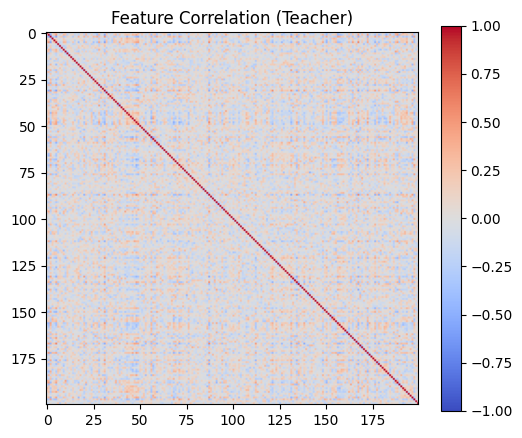

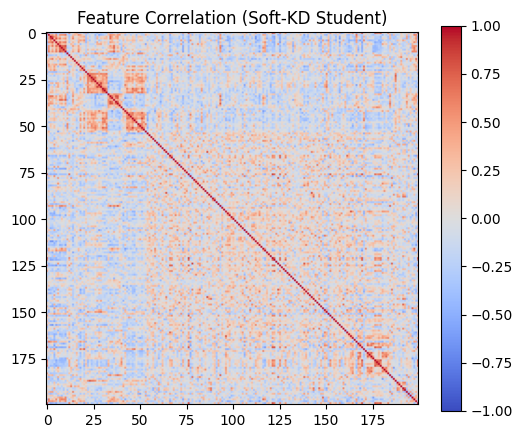

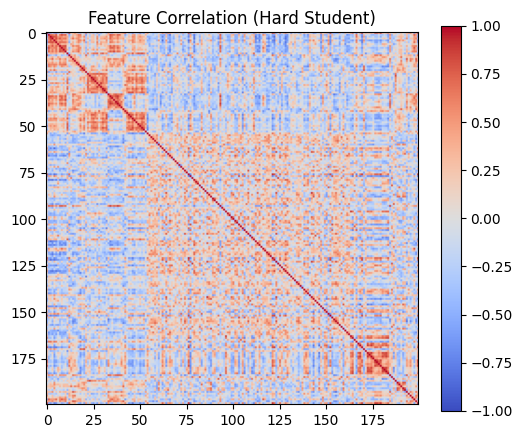

Mean |Teacher–Soft| diff: 0.20879031692556846
Mean |Teacher–Hard| diff: 0.2877781354022376

--- t-SNE VISUALS ---


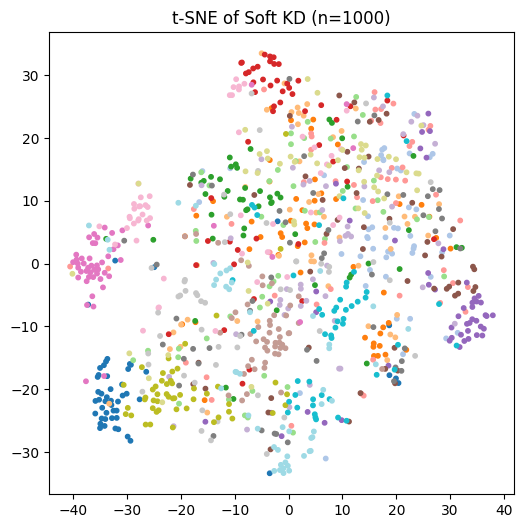

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


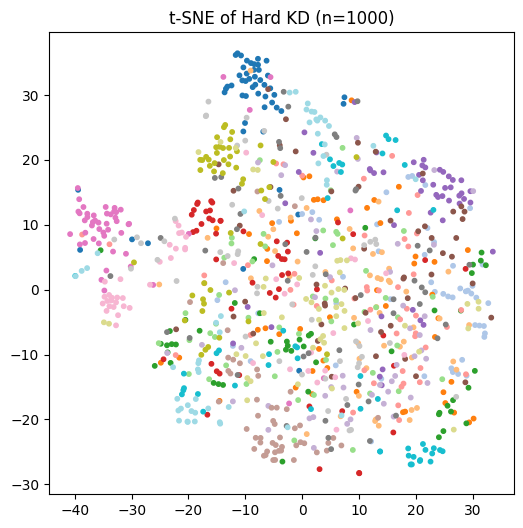

In [ ]:
print("\n--- FINAL EVALUATION ---")
soft_stats = evaluate_detailed(student_soft, teacher, val_loader)
hard_stats = evaluate_detailed(student_hard, teacher, val_loader)

print("\n--- CORRELATION MATRICES ---")
corr_t = correlation_heatmap(teacher, val_loader, title="Teacher")
corr_s = correlation_heatmap(student_soft, val_loader, title="Soft-KD Student")
corr_h = correlation_heatmap(student_hard, val_loader, title="Hard Student")

print("Mean |Teacher–Soft| diff:", np.abs(corr_t - corr_s).mean())
print("Mean |Teacher–Hard| diff:", np.abs(corr_t - corr_h).mean())

print("\n--- t-SNE VISUALS ---")
tsne_visual(student_soft, val_loader, title="Soft KD")
tsne_visual(student_hard, val_loader, title="Hard KD")


In [ ]:
import pandas as pd
history = []
for ep in range(1, EPOCHS+1):
    ...
    stats = evaluate_detailed(student, teacher, val_loader)
    history.append({"epoch":ep, **stats})
pd.DataFrame(history).to_csv("/content/drive/MyDrive/KD_VGG_Models/kd_eval_log.csv", index=False)


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


Top-1: 35.32%, Top-5: 60.67%
Avg CE Loss: 3.1033, Avg KL Loss: 0.8385
Mean Per-Class Acc: 0.35%


LABEL SMOOTHING


In [ ]:
# ---------- FIXED TRAINING: VGG11 + LABEL SMOOTHING KD ----------
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import os

# ---------- CONFIG ----------
EPOCHS = 45
LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
T = 4.0
ALPHA = 0.7
EPS = 0.1

# ---------- LABEL SMOOTHING ----------
def label_smoothing(targets, n_classes, eps=0.1):
    with torch.no_grad():
        out = torch.full((targets.size(0), n_classes),
                         eps / (n_classes - 1), device=targets.device)
        out.scatter_(1, targets.unsqueeze(1), 1 - eps)
    return out

# ---------- KD + LABEL SMOOTHING LOSS ----------
def kd_ls_loss(student_logits, teacher_logits, targets,
               T=T, alpha=ALPHA, eps=EPS):
    smoothed = label_smoothing(targets, student_logits.size(1), eps)
    log_s = F.log_softmax(student_logits / T, dim=1)
    soft_t = F.softmax(teacher_logits / T, dim=1)
    kl = F.kl_div(log_s, soft_t, reduction='batchmean') * (T*T)
    ce = -(smoothed * F.log_softmax(student_logits, dim=1)).sum(dim=1).mean()
    return alpha * kl + (1 - alpha) * ce

# ---------- FIXED ACCURACY FUNCTION ----------
def topk_acc(output, target, topk=(1, 5)):
    """Compute top-k accuracies robustly across PyTorch versions."""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, dim=1, largest=True, sorted=True)   # [B,k]
    # Compare each row’s predictions to its label
    correct = pred.eq(target.view(-1, 1).expand_as(pred))           # [B,k]
    res = []
    for k in topk:
        correct_k = correct[:, :k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size).item())
    return res

def evaluate(model, loader):
    model.eval(); top1_sum=top5_sum=total=0
    with torch.no_grad():
        for x,y in loader:
            x,y=x.to(device),y.to(device)
            out=model(x)
            top1,top5=topk_acc(out,y)
            top1_sum+=top1*y.size(0); top5_sum+=top5*y.size(0)
            total+=y.size(0)
    return top1_sum/total, top5_sum/total

# ---------- TRAIN FUNCTION ----------
def train_vgg11_label_smoothing(teacher, train_loader, val_loader,
                                epochs=EPOCHS, lr=LR, T=T, alpha=ALPHA, eps=EPS):
    student = models.vgg11(num_classes=num_classes).to(device)
    opt = torch.optim.SGD(student.parameters(), lr=lr,
                          momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    # unique save path (avoid overwrite)
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    save_dir = "/content/drive/MyDrive/KD_VGG11_LabelSmoothing_NEW_STUDENT"
    os.makedirs(save_dir, exist_ok=True)

    print("\n=== Training NEW Student (VGG11, Label Smoothing + KD) ===")
    for ep in range(1, epochs+1):
        student.train()
        total, correct, loss_sum = 0, 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=False):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.no_grad():
                t_logits = teacher(x)
            s_logits = student(x)
            loss = kd_ls_loss(s_logits, t_logits, y, T=T, alpha=alpha, eps=eps)
            opt.zero_grad(); loss.backward(); opt.step()

            loss_sum += loss.item() * y.size(0)
            _, pred = s_logits.max(1)
            correct += pred.eq(y).sum().item(); total += y.size(0)

        train_acc = 100 * correct / total
        val1, val5 = evaluate(student, val_loader)
        print(f"Epoch {ep:02d}: TrainAcc={train_acc:.2f}% | ValTop1={val1:.2f}% | ValTop5={val5:.2f}%")

        # save every 5 epochs
        if ep % 5 == 0:
            ckpt = os.path.join(save_dir, f"VGG11_LSRKD_ep{ep:03d}.pth")
            torch.save(student.state_dict(), ckpt)
            print(f"Checkpoint saved: {ckpt}")
        torch.cuda.empty_cache()

    print("=== Training complete ===")
    final_path = os.path.join(save_dir, "VGG11_LSRKD_FINAL.pth")
    torch.save(student.state_dict(), final_path)
    print(f"Final model saved to: {final_path}")
    return student

# ---------- RUN ----------
student_vgg11_lsrkd = train_vgg11_label_smoothing(
    teacher, train_loader, val_loader, epochs=EPOCHS
)

# ---------- FINAL EVALUATION ----------
print("\n--- Final Evaluation ---")
train1, train5 = evaluate(student_vgg11_lsrkd, train_loader)
val1, val5 = evaluate(student_vgg11_lsrkd, val_loader)
print(f"Train: Top-1={train1:.2f}% | Top-5={train5:.2f}%")
print(f"Val:   Top-1={val1:.2f}% | Top-5={val5:.2f}%")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Training NEW Student (VGG11, Label Smoothing + KD) ===


Epoch 01: TrainAcc=0.52% | ValTop1=0.61% | ValTop5=2.68%


Epoch 02: TrainAcc=0.63% | ValTop1=1.26% | ValTop5=3.93%


Epoch 03: TrainAcc=1.07% | ValTop1=1.50% | ValTop5=5.95%


Epoch 04: TrainAcc=1.40% | ValTop1=1.94% | ValTop5=8.44%


Epoch 05: TrainAcc=2.11% | ValTop1=3.13% | ValTop5=11.36%
Checkpoint saved: /content/drive/MyDrive/KD_VGG11_LabelSmoothing_NEW_STUDENT/VGG11_LSRKD_ep005.pth


Epoch 06: TrainAcc=3.06% | ValTop1=4.38% | ValTop5=14.49%


Epoch 07: TrainAcc=3.91% | ValTop1=5.21% | ValTop5=16.19%


Epoch 08: TrainAcc=4.83% | ValTop1=6.10% | ValTop5=18.54%


Epoch 09: TrainAcc=5.78% | ValTop1=7.04% | ValTop5=20.42%


Epoch 10: TrainAcc=6.64% | ValTop1=7.66% | ValTop5=22.61%
Checkpoint saved: /content/drive/MyDrive/KD_VGG11_LabelSmoothing_NEW_STUDENT/VGG11_LSRKD_ep010.pth


Epoch 11: TrainAcc=7.54% | ValTop1=8.87% | ValTop5=24.44%


Epoch 12: TrainAcc=8.38% | ValTop1=9.48% | ValTop5=26.28%


Epoch 13/45:  21%|██        | 322/1563 [00:34<02:11,  9.44it/s]

In [ ]:
# ---------- POST-TRAIN EVALUATION ----------
def correlation_matrix(model, loader, n_batches=10):
    model.eval(); feats=[]
    with torch.no_grad():
        for i,(x,_) in enumerate(loader):
            if i>=n_batches: break
            feats.append(model(x.to(device)).cpu().numpy())
    feats=np.concatenate(feats,axis=0)
    return np.corrcoef(feats.T)

print("\n--- Final Evaluation ---")
train1,train5=evaluate(student,train_loader)
val1,val5=evaluate(student,val_loader)
print(f"Train: Top-1={train1:.2f}% | Top-5={train5:.2f}%")
print(f"Val:   Top-1={val1:.2f}% | Top-5={val5:.2f}%")

print("\n--- Correlation Matrices ---")
corr_teacher=correlation_matrix(teacher,val_loader)
corr_student=correlation_matrix(student,val_loader)
print("Mean |Teacher–Student| corr-diff:",
      np.abs(corr_teacher - corr_student).mean())

def tsne_summary(model, loader, n_samples=1000):
    model.eval(); X,Y=[],[]
    with torch.no_grad():
        for x,y in loader:
            X.append(model(x.to(device)).cpu()); Y.append(y)
            if len(torch.cat(Y))>=n_samples: break
    X=torch.cat(X)[:n_samples]; Y=torch.cat(Y)[:n_samples]
    tsne=TSNE(n_components=2,init='pca',random_state=0).fit_transform(X)
    print(f"t-SNE done: {tsne.shape}, {Y.unique().numel()} classes")
    return tsne,Y

print("\nRunning t-SNE (student)…")
tsne_out,Ys=tsne_summary(student,val_loader)